# Banking and Unemployment
---
The below script explores the relationship between states with high unemployment rates and bank counts per state.

In this script, we retrieved and plotted data from the 2013 US Census and Google Places API to show the relationship between various socioeconomic parameters and bank count across 700 randomly selected zip codes. We used Pandas, Numpy, Matplotlib, Requests, Census API, and Google API to accomplish our task.

In [3]:
# Dependencies
from census import Census
from config import (census_key, gkey)
import gmaps
import numpy as np
import pandas as pd
import requests
import time
import us
import matplotlib.pyplot as plt
import seaborn as sns

# Census API Key
c = Census(census_key, year=2016)

In [4]:
c.acs5.get(('NAME', 'B25034_010E'),
          {'for': 'state:{}'.format(us.states.MD.fips)})

[{'NAME': 'Maryland', 'B25034_010E': 133511.0, 'state': '24'}]

## Data Retrieval

In [6]:
# Run Census Search to retrieve data on all states (2016 ACS5 Census)
# See: https://github.com/CommerceDataService/census-wrapper for library documentation
# See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels
census_data = c.acs5.get(('NAME'          #state name
                          ,'B01003_001E'  #population total
                          ,'B17001_001E'  #poverty status total
                          ,'B17001_002E'  #poverty status below poverty level
                          ,'B19301_001E'  #total per capita income
                          ,'B23025_001E'  #total labor force 16 years and over
                          ,'B23025_004E'  #total Civilian force 16 years and over, employed
                          ,'B23025_005E'  #Unemployment Civilian Count
                          ,'B23025_006E'  #total Armed forces 16 years and over, employed
                          ,'B23025_007E'  #total not labor force
                          ,'B25003_001E'  #total houses
                          ,'B25003_002E'  #Total!!Owner occupied
                          ,'B25003_003E'  #Total!!Renter occupied
                          ,'B25081_002E'  #Houses with mortgage
                          ,'B992701_001E' #total people
                          ,'B992701_002E' #people with medical coverage
                          ,'B992701_003E' #people without medical coverage
                          ), {
                         'for': 'state:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# # # Column Reordering
census_pd = census_pd.rename(columns={ 'NAME': 'State'        #state name
                                      ,'B01003_001E':'Total Population'  #population total
                                      ,'B17001_001E':'Total Poverty'  #poverty status total
                                      ,'B17001_002E':'People Below Poverty Level'  #poverty status below poverty level
                                      ,'B19301_001E':'Per Capita Income'  #total per capita income
                                      ,'B23025_001E':'Total Labor Force'  #total labor force 16 years and over
                                      ,'B23025_004E':'Total Employed Civilian'  #total Civilian force 16 years and over, employed
                                      ,'B23025_005E':'Unemployment Civilian'  #Unemployment Civilian Count
                                      ,'B23025_006E':'Armed Forces Employment'  #total Armed forces 16 years and over, employed
                                      ,'B23025_007E':'Total Not Labor Force'  #total not labor force
                                      ,'B25003_001E':'Total Houses'  #total houses
                                      ,'B25003_002E':'Houses with owners'  #Total!!Owner occupied
                                      ,'B25003_003E':'Houses with renters'  #Total!!Renter occupied
                                      ,'B25081_002E':'Houses with mortgage'  #Houses with mortgage
                                      ,'B992701_001E':'Total People' #total people
                                      ,'B992701_002E':'Total People with insurance' #people with medical coverage
                                      ,'B992701_003E':'Total People withou insurance'}) #people without medical coverage

# # Add in Employment Rate (Employment Count / Population)
# census_pd["Unemployment Rate"] = 100 * \
#     census_pd["Unemployment Count"].astype(
#         int) / census_pd["Population"].astype(int)

# # Final DataFrame
# census_pd = census_pd[["Zipcode", "Population", "Unemployment Rate"]]



In [7]:
# Visualize
print(len(census_pd))
census_pd.head()

52


,Total Population,Total Poverty,People Below Poverty Level,Per Capita Income,Total Labor Force,Total Employed Civilian,Unemployment Civilian,Armed Forces Employment,Total Not Labor Force,Total Houses,Houses with owners,Houses with renters,Houses with mortgage,Total People,Total People with insurance,Total People withou insurance,State,state
0,4841164.0,4720592.0,868666.0,24736.0,3864302.0,2042025.0,184479.0,12150.0,1625648.0,1851061.0,1267824.0,583237.0,730637.0,4761291.0,657349.0,4103942.0,Alabama,01
1,736855.0,719064.0,72826.0,34191.0,568732.0,353954.0,30139.0,16382.0,168257.0,250235.0,159313.0,90922.0,103704.0,712964.0,83618.0,629346.0,Alaska,02
2,6728577.0,6573523.0,1165636.0,26686.0,5290839.0,2879372.0,249972.0,17373.0,2144122.0,2448919.0,1531878.0,917041.0,991361.0,6620233.0,1024109.0,5596124.0,Arizona,04
3,2968472.0,2881404.0,542431.0,23401.0,2339307.0,1266552.0,93190.0,4445.0,975120.0,1141480.0,749452.0,392028.0,417765.0,2915402.0,346839.0,2568563.0,Arkansas,05
4,38654206.0,37913144.0,6004257.0,31458.0,30565746.0,17577142.0,1683726.0,130452.0,11174426.0,12807387.0,6929007.0,5878380.0,5000119.0,38151997.0,4892528.0,33259469.0,California,06


## Combine Data

In [8]:
# Import the original data we analyzed earlier. Use dtype="object" to match other
samhsa_data = pd.read_csv(
    '../Resources/SAMHSA/Any_Mental_Illness_2016.csv', dtype="object", encoding="utf-8")

# Visualize
samhsa_data.head()

samhsa_data.drop(['Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15'], axis=1, inplace=True)

In [9]:
samhsa_data.head()

,State,18 or Older Estimate,18 or Older 95% CI (Lower),18 or Older 95% CI (Upper),18-25 Estimate,18-25 95% CI (Lower),18-25 95% CI (Upper),26 or Older Estimate,26 or Older 95% CI (Lower),26 or Older 95% CI (Upper)
0,Alabama,19.95%,17.96%,22.10%,21.52%,18.77%,24.56%,19.69%,17.44%,22.16%
1,Alaska,20.32%,18.30%,22.50%,27.34%,24.11%,30.83%,19.14%,16.90%,21.59%
2,Arizona,18.02%,15.98%,20.27%,22.39%,19.29%,25.83%,17.30%,15.01%,19.86%
3,Arkansas,20.73%,18.70%,22.91%,24.46%,21.41%,27.79%,20.11%,17.83%,22.61%
4,California,18.18%,17.14%,19.26%,24.75%,22.97%,26.62%,17.06%,15.89%,18.30%


In [10]:
# # Merge the two data sets along zip code
census_data_complete = pd.merge(
    samhsa_data, census_pd, how="outer", on=["State", "State"])

# Save the revised Data Frame as a csv
census_data_complete.to_csv(
    "../Resources/Census_Data/census_merged.csv", encoding="utf-8", index=False)

# Visualize
census_data_complete.head()
# census_data_complete.columns

,State,18 or Older Estimate,18 or Older 95% CI (Lower),18 or Older 95% CI (Upper),18-25 Estimate,18-25 95% CI (Lower),18-25 95% CI (Upper),26 or Older Estimate,26 or Older 95% CI (Lower),26 or Older 95% CI (Upper),...,Armed Forces Employment,Total Not Labor Force,Total Houses,Houses with owners,Houses with renters,Houses with mortgage,Total People,Total People with insurance,Total People withou insurance,state
0,Alabama,19.95%,17.96%,22.10%,21.52%,18.77%,24.56%,19.69%,17.44%,22.16%,...,12150.0,1625648.0,1851061.0,1267824.0,583237.0,730637.0,4761291.0,657349.0,4103942.0,01
1,Alaska,20.32%,18.30%,22.50%,27.34%,24.11%,30.83%,19.14%,16.90%,21.59%,...,16382.0,168257.0,250235.0,159313.0,90922.0,103704.0,712964.0,83618.0,629346.0,02
2,Arizona,18.02%,15.98%,20.27%,22.39%,19.29%,25.83%,17.30%,15.01%,19.86%,...,17373.0,2144122.0,2448919.0,1531878.0,917041.0,991361.0,6620233.0,1024109.0,5596124.0,04
3,Arkansas,20.73%,18.70%,22.91%,24.46%,21.41%,27.79%,20.11%,17.83%,22.61%,...,4445.0,975120.0,1141480.0,749452.0,392028.0,417765.0,2915402.0,346839.0,2568563.0,05
4,California,18.18%,17.14%,19.26%,24.75%,22.97%,26.62%,17.06%,15.89%,18.30%,...,130452.0,11174426.0,12807387.0,6929007.0,5878380.0,5000119.0,38151997.0,4892528.0,33259469.0,06


In [12]:
# Import the data analyzed earlier.

final_data_df = pd.read_csv(
    '../Resources/Census_Data/final_data.csv', encoding="utf-8")

# # final_data_df.columns
final_data_df['18 or Older % MI\nEstimate'] = final_data_df['18 or Older % MI\nEstimate']*100

final_data_df.head()

,State,18 or Older population %,18 or Older population,18 or Older % MI Estimate,18 or Older MI Estimate,Total Population,Total Poverty,People Below Poverty %,Total Labor Force 16 and over,Unemployment Civilian,Unemployment Civilian %,Total People,Total People without insurance,Total People without insurance %
0,Alabama,77.4,3747061,19.95,747539,4841164,4720592,18.401633,3864302,184479,3.810633,4761291,4103942,86.193892
1,Alaska,74.8,551168,20.32,111997,736855,719064,10.127888,568732,30139,4.090221,712964,629346,88.271778
2,Arizona,76.5,5147361,18.02,927554,6728577,6573523,17.732288,5290839,249972,3.715080,6620233,5596124,84.530620
3,Arkansas,76.4,2267913,20.73,470138,2968472,2881404,18.825232,2339307,93190,3.139326,2915402,2568563,88.103219
4,California,76.8,29686430,18.18,5396993,38654206,37913144,15.836874,30565746,1683726,4.355868,38151997,33259469,87.176220


In [13]:
# poverty and mi correlation

poverty_df = final_data_df[['State','People Below Poverty %','18 or Older % MI\nEstimate']]
poverty_df = poverty_df.sort_values(by=['People Below Poverty %'])
poverty_df = poverty_df.reset_index(drop=True)
poverty_df.head()

,State,People Below Poverty %,18 or Older % MI Estimate
0,New Hampshire,8.533285,19.15
1,Maryland,9.911999,16.94
2,Alaska,10.127888,20.32
3,Connecticut,10.359137,18.18
4,Hawaii,10.798312,16.27


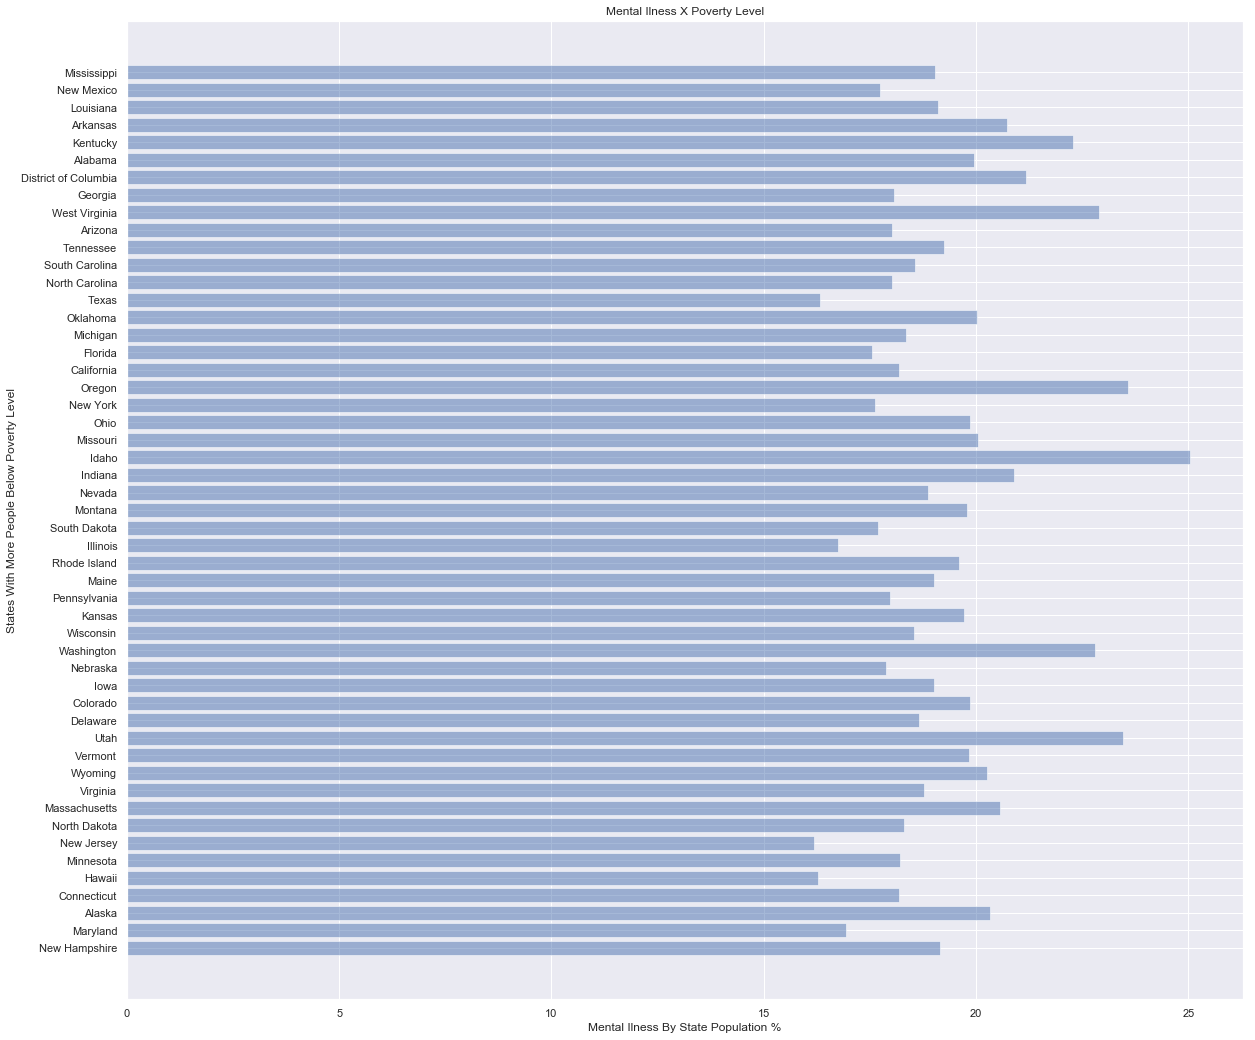

In [15]:
# Mental Ilness X Poverty Level
sns.set()
plt.figure(figsize=(20,18))
plt.barh(poverty_df['State'], poverty_df['18 or Older % MI\nEstimate']
        , align='center', alpha=0.5, )
plt.yticks(poverty_df['State'])
plt.ylabel('States With More People Below Poverty Level')
plt.xlabel('Mental Ilness By State Population %')
plt.title('Mental Ilness X Poverty Level')
plt.savefig('../Resources/Census_Data/mental_poverty.png')

plt.show()


In [16]:
# Unemployment and mi correlation

unemployment_df = final_data_df[['State','Unemployment Civilian %','18 or Older % MI\nEstimate']]
unemployment_df = unemployment_df.sort_values(by=['Unemployment Civilian %'])
unemployment_df = unemployment_df.reset_index(drop=True)
unemployment_df.head()

,State,Unemployment Civilian %,18 or Older % MI Estimate
0,North Dakota,1.528196,18.30
1,South Dakota,2.189745,17.70
2,Nebraska,2.261464,17.88
3,Iowa,2.423526,19.02
4,Utah,2.479763,23.47


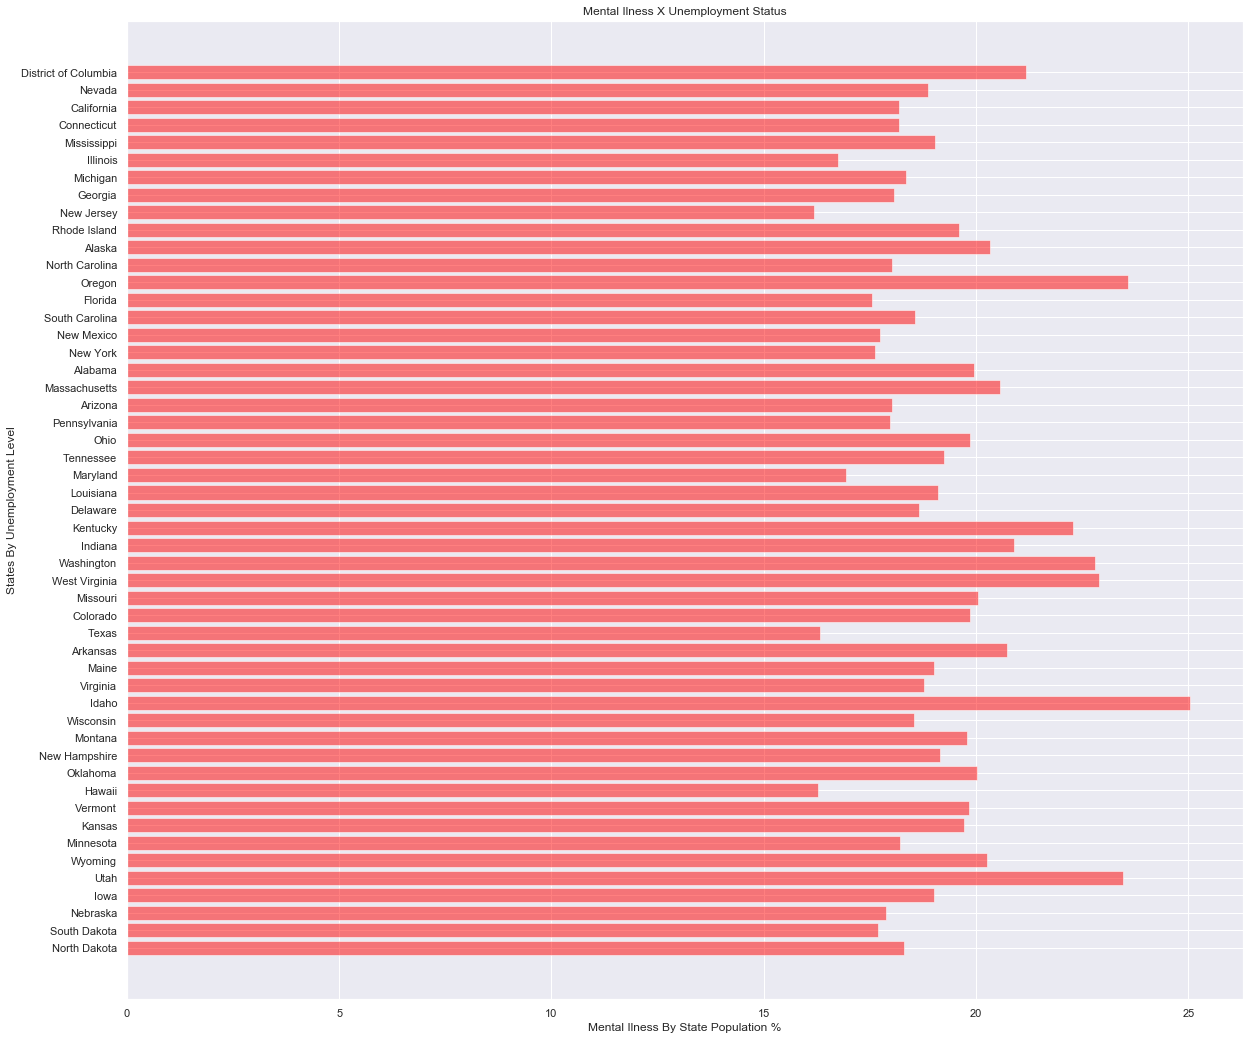

In [18]:
# Mental Ilness X Employment
sns.set()
plt.figure(figsize=(20,18))
plt.barh(unemployment_df['State'], unemployment_df['18 or Older % MI\nEstimate']
        , align='center', alpha=0.5, color='red')
plt.yticks(unemployment_df['State'])
plt.ylabel('States By Unemployment Level')
plt.xlabel('Mental Ilness By State Population %')
plt.title('Mental Ilness X Unemployment Status')
plt.savefig('../Resources/Census_Data/mental_unemployment.png')

plt.show()

In [19]:
# Health Insurance and mi correlation

insurance_df = final_data_df[['State','Total People without insurance %','18 or Older % MI\nEstimate']]
insurance_df = insurance_df.sort_values(by=['Total People without insurance %'])
insurance_df = insurance_df.reset_index(drop=True)
insurance_df.head()

,State,Total People without insurance %,18 or Older % MI Estimate
0,District of Columbia,84.439340,21.17
1,Arizona,84.530620,18.02
2,Florida,84.830485,17.54
3,Massachusetts,85.150202,20.57
4,Hawaii,85.763048,16.27


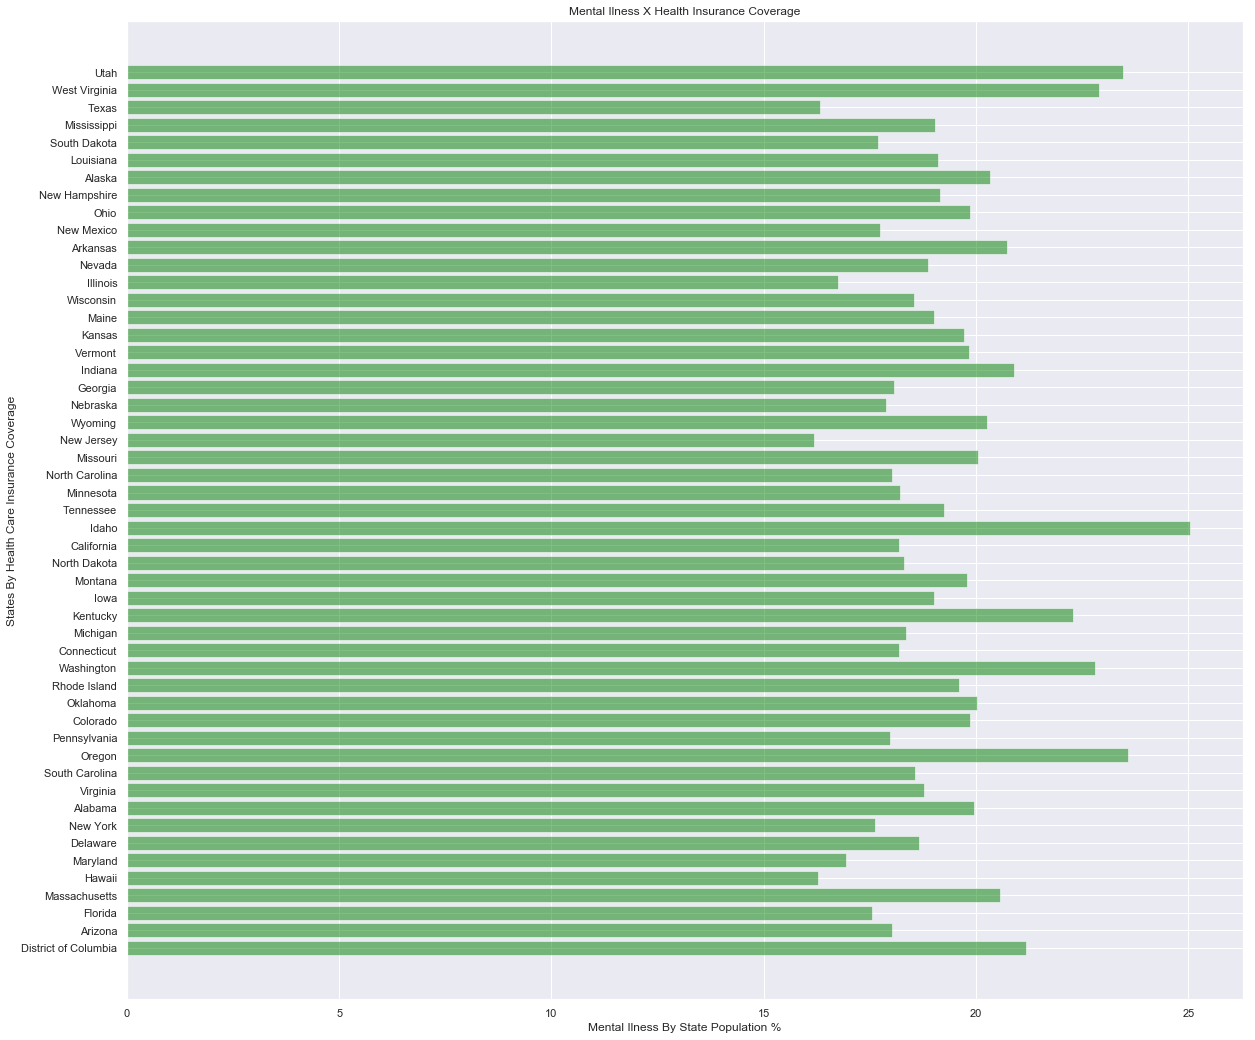

In [20]:
# Mental Ilness X Health Insurance
sns.set()
plt.figure(figsize=(20,18))
plt.barh(insurance_df['State'], insurance_df['18 or Older % MI\nEstimate']
        , align='center', alpha=0.5, color='green')
plt.yticks(insurance_df['State'])
plt.ylabel('States By Health Care Insurance Coverage')
plt.xlabel('Mental Ilness By State Population %')
plt.title('Mental Ilness X Health Insurance Coverage')
plt.savefig('../Resources/Census_Data/mental_insurance.png')
 
plt.show()